In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile
class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta
        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []
        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None
    def reset(self):
        # re-initialize all variables from our constructor
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None
    def is_data_iter(self, data):
        # define the set of class types we will check for
        iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
             "DataFrameIterator", "Iterator", "Sequence"]
        # return whether our data is an iterator
        return data.__class__.__name__ in iterClasses
    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add log it to the list of
        # learning rates that we've tried
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)
        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)
        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss
        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return
        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth
        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)
    def find(self, trainData, startLR, endLR, epochs=None,
        stepsPerEpoch=None, batchSize=32, sampleSize=2048,
        verbose=1):
        # reset our class-specific variables
        self.reset()
        # determine if we are using a data generator or not
        useGen = self.is_data_iter(trainData)
        # if we're using a generator and the steps per epoch is not
        # supplied, raise an error
        if useGen and stepsPerEpoch is None:
            msg = "Using generator without supplying stepsPerEpoch"
            raise Exception(msg)
        # if we're not using a generator then our entire dataset must
        # already be in memory
        elif not useGen:
            # grab the number of samples in the training data and
            # then derive the number of steps per epoch
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))
        # if no number of training epochs are supplied, compute the
        # training epochs based on a default sample size
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch
        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
        # create a temporary file path for the model weights and
        # then save the weights (so we can reset the weights when we
        # are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)
        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)


        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))
        # check to see if we are using a data iterator
        if useGen:
            self.model.fit(
                x=trainData,
                steps_per_epoch=stepsPerEpoch,
                epochs=epochs,
                verbose=verbose,
                callbacks=[callback])
        # otherwise, our entire training data is already in memory
        else:
            # train our model using Keras' fit method
            self.model.fit(
                x=trainData[0], y=trainData[1],
                batch_size=batchSize,
                epochs=epochs,
                callbacks=[callback],
                verbose=verbose)
        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)
    def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]
        # plot the learning rate vs. loss
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)
            

In [3]:
import os
# initialize the list of class label names
CLASSES = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
# define the minimum learning rate, maximum learning rate, batch size,
# step size, CLR method, and number of epochs
MIN_LR = 1e-5
MAX_LR = 1e-2
BATCH_SIZE = 64
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 48
# define the path to the output learning rate finder plot, training
# history plot and cyclical learning rate plot
LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])
CLR_PLOT_PATH = os.path.sep.join(["output", "clr_plot.png"])


In [4]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [5]:
import matplotlib
matplotlib.use("Agg")
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

In [6]:
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")

[INFO] loading Fashion MNIST data...


In [7]:
from tensorflow.keras.layers import BatchNormalization,Conv2D, AveragePooling2D, MaxPooling2D, Activation, Dropout, Dense, Flatten , Input, concatenate
from tensorflow.keras.models import Model
from keras import backend as K
class MiniGoogLeNet:
    @staticmethod
    def conv_module(x, K, kX, kY, stride, chanDim, padding="same"):
        # define a CONV => BN => RELU pattern
        x = Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
        # return the block
        return x
    @staticmethod
    def inception_module(x, numK1x1, numK3x3, chanDim):
      # define two CONV modules, then concatenate across the
      # channel dimension
        conv_1x1 = MiniGoogLeNet.conv_module(x, numK1x1, 1, 1,(1, 1), chanDim)
        conv_3x3 = MiniGoogLeNet.conv_module(x, numK3x3, 3, 3,
        (1, 1), chanDim)
        x = concatenate([conv_1x1, conv_3x3], axis=chanDim)
# return the block
        return x
    @staticmethod
    def downsample_module(x, K, chanDim):
        conv_3x3 = MiniGoogLeNet.conv_module(x, K, 3, 3, (2, 2),
        chanDim, padding="valid")
        pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
        x = concatenate([conv_3x3, pool], axis=chanDim)
        # return the block
        return x
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # define the model input and first CONV module
        inputs = Input(shape=inputShape)
        
        
        x = MiniGoogLeNet.conv_module(inputs, 96, 3, 3, (1, 1), chanDim)
        # two Inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 32, 32, chanDim)
        x = MiniGoogLeNet.inception_module(x, 32, 48, chanDim)
        x = MiniGoogLeNet.downsample_module(x, 80, chanDim)
        # four Inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 112, 48, chanDim)
        x = MiniGoogLeNet.inception_module(x, 96, 64, chanDim)
        x = MiniGoogLeNet.inception_module(x, 80, 80, chanDim)
        x = MiniGoogLeNet.inception_module(x, 48, 96, chanDim)
        x = MiniGoogLeNet.downsample_module(x, 96, chanDim)
        # two Inception modules followed by global POOL and dropout
        x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
        x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
        x = AveragePooling2D((7, 7))(x)
        x = Dropout(0.5)(x)
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes)(x)
        x = Activation("softmax")(x)
        # create the model
        model = Model(inputs, x, name="googlenet")
        # return the constructed network architecture
        return model

Using TensorFlow backend.


In [28]:
print("[INFO] compiling model...")
# opt = SGD(lr=MIN_LR, momentum=0.9)
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(lr = MIN_LR)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [26]:
MIN_LR = 1e-4
MAX_LR = 1e-2
BATCH_SIZE = 64
STEP_SIZE = 8
CLR_METHOD = "exp_range"
NUM_EPOCHS = 48

[INFO] finding learning rate...
Epoch 1/3
938/938 [==============================] - 17s 18ms/step - loss: 2.5793 - accuracy: 0.1013
Epoch 2/3
938/938 [==============================] - 18s 19ms/step - loss: 2.1144 - accuracy: 0.2494
Epoch 3/3
938/938 [==============================] - 20s 21ms/step - loss: 1.0307 - accuracy: 0.6534
[INFO] learning rate finder complete
[INFO] examine plot and adjust learning rates before training


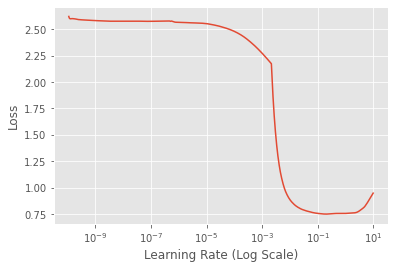

In [25]:
# initialize the learning rate finder and then train with learning
# rates ranging from 1e-10 to 1e+1
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    1e-10, 1e+1,
    stepsPerEpoch=np.ceil((len(trainX) / float(BATCH_SIZE))),
    batchSize=BATCH_SIZE)
# plot the loss for the various learning rates and save the
# resulting plot to disk
lrf.plot_loss()
plt.savefig(LRFIND_PLOT_PATH)
# gracefully exit the script so we can adjust our learning rates
# in the config and then train the network for our full set of
# epochs
print("[INFO] learning rate finder complete")
print("[INFO] examine plot and adjust learning rates before training")

In [29]:
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
    mode=CLR_METHOD,
    base_lr=MIN_LR,
    max_lr=MAX_LR,
    step_size=stepSize)
# train the network
print("[INFO] training network...")
H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[clr],
    verbose=1)
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=CLASSES))

[INFO] training network...
Epoch 1/48
937/937 [==============================] - 20s 22ms/step - loss: 0.6082 - accuracy: 0.7775 - val_loss: 1.5517 - val_accuracy: 0.6736
Epoch 2/48
937/937 [==============================] - 20s 22ms/step - loss: 0.3962 - accuracy: 0.8568 - val_loss: 0.8594 - val_accuracy: 0.7914
Epoch 3/48
937/937 [==============================] - 23s 24ms/step - loss: 0.3493 - accuracy: 0.8743 - val_loss: 0.5173 - val_accuracy: 0.8409
Epoch 4/48
937/937 [==============================] - 24s 26ms/step - loss: 0.3215 - accuracy: 0.8837 - val_loss: 0.3445 - val_accuracy: 0.8729
Epoch 5/48
937/937 [==============================] - 25s 26ms/step - loss: 0.3014 - accuracy: 0.8933 - val_loss: 0.3386 - val_accuracy: 0.8957
Epoch 6/48
937/937 [==============================] - 25s 27ms/step - loss: 0.2915 - accuracy: 0.8986 - val_loss: 0.5003 - val_accuracy: 0.8554
Epoch 7/48
937/937 [==============================] - 26s 27ms/step - loss: 0.2830 - accuracy: 0.9014 - val_l

In [21]:
%matplotlib inline

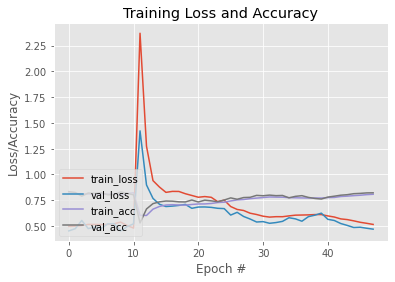

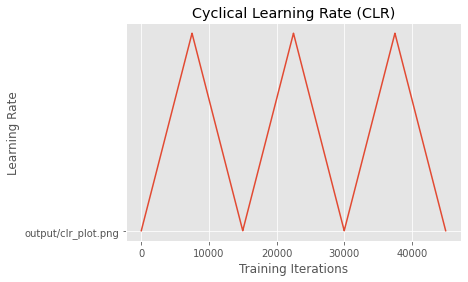

In [22]:
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)
# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.plot(CLR_PLOT_PATH)

In [15]:
#Without LR finder
# [INFO] training network...
# Epoch 1/48
# 937/937 [==============================] - 19s 20ms/step - loss: 403.8160 - accuracy: 0.1228 - val_loss: 8.4648 - val_accuracy: 0.2617
# Epoch 2/48
# 937/937 [==============================] - 21s 22ms/step - loss: 12.1088 - accuracy: 0.3101 - val_loss: 3.9169 - val_accuracy: 0.4181
# Epoch 3/48
# 937/937 [==============================] - 22s 24ms/step - loss: 3.9821 - accuracy: 0.4264 - val_loss: 2.4392 - val_accuracy: 0.4383
# Epoch 4/48
# 937/937 [==============================] - 23s 25ms/step - loss: 2.8262 - accuracy: 0.4805 - val_loss: 1.6821 - val_accuracy: 0.5607
# Epoch 5/48
# 937/937 [==============================] - 24s 25ms/step - loss: 1.8418 - accuracy: 0.5285 - val_loss: 1.3445 - val_accuracy: 0.6507
# Epoch 6/48
# 937/937 [==============================] - 24s 26ms/step - loss: 2.0638 - accuracy: 0.5427 - val_loss: 4.9757 - val_accuracy: 0.2432
# Epoch 7/48
# 937/937 [==============================] - 24s 26ms/step - loss: 1.7461 - accuracy: 0.5416 - val_loss: 1.2362 - val_accuracy: 0.6240
# Epoch 8/48
# 937/937 [==============================] - 24s 26ms/step - loss: 1.5145 - accuracy: 0.5779 - val_loss: 2.2194 - val_accuracy: 0.3266
# Epoch 9/48
# 937/937 [==============================] - 24s 26ms/step - loss: 1.3332 - accuracy: 0.6025 - val_loss: 1.0169 - val_accuracy: 0.6377
# Epoch 10/48
# 937/937 [==============================] - 25s 26ms/step - loss: 1.1032 - accuracy: 0.6494 - val_loss: 0.8189 - val_accuracy: 0.7013
# Epoch 11/48
# 937/937 [==============================] - 24s 26ms/step - loss: 1.0602 - accuracy: 0.6694 - val_loss: 0.8451 - val_accuracy: 0.7161
# Epoch 12/48
# 937/937 [==============================] - 24s 26ms/step - loss: 0.8798 - accuracy: 0.6872 - val_loss: 0.7303 - val_accuracy: 0.7297
# Epoch 13/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.8435 - accuracy: 0.7020 - val_loss: 0.7308 - val_accuracy: 0.7431
# Epoch 14/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.8001 - accuracy: 0.7137 - val_loss: 0.6829 - val_accuracy: 0.7489
# Epoch 15/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.7752 - accuracy: 0.7227 - val_loss: 0.6512 - val_accuracy: 0.7560
# Epoch 16/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.7391 - accuracy: 0.7292 - val_loss: 0.6414 - val_accuracy: 0.7611
# Epoch 17/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.7358 - accuracy: 0.7301 - val_loss: 0.6596 - val_accuracy: 0.7539
# Epoch 18/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.7638 - accuracy: 0.7281 - val_loss: 0.6580 - val_accuracy: 0.7565
# Epoch 19/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.7588 - accuracy: 0.7275 - val_loss: 0.7185 - val_accuracy: 0.7432
# Epoch 20/48
# 937/937 [==============================] - 24s 26ms/step - loss: 0.8009 - accuracy: 0.7234 - val_loss: 0.6754 - val_accuracy: 0.7548
# Epoch 21/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.7853 - accuracy: 0.7275 - val_loss: 0.6615 - val_accuracy: 0.7587
# Epoch 22/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.7676 - accuracy: 0.7264 - val_loss: 0.7220 - val_accuracy: 0.7324
# Epoch 23/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.7549 - accuracy: 0.7288 - val_loss: 0.7455 - val_accuracy: 0.7096
# Epoch 24/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.7819 - accuracy: 0.7285 - val_loss: 0.7615 - val_accuracy: 0.7042
# Epoch 25/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.7302 - accuracy: 0.7358 - val_loss: 0.7742 - val_accuracy: 0.7054
# Epoch 26/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.6926 - accuracy: 0.7447 - val_loss: 0.6172 - val_accuracy: 0.7683
# Epoch 27/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.7426 - accuracy: 0.7376 - val_loss: 0.6574 - val_accuracy: 0.7343
# Epoch 28/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.6708 - accuracy: 0.7500 - val_loss: 0.5810 - val_accuracy: 0.7747
# Epoch 29/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.6400 - accuracy: 0.7625 - val_loss: 0.5569 - val_accuracy: 0.7888
# Epoch 30/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.6105 - accuracy: 0.7712 - val_loss: 0.5698 - val_accuracy: 0.7829
# Epoch 31/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.6036 - accuracy: 0.7753 - val_loss: 0.5242 - val_accuracy: 0.8029
# Epoch 32/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.5850 - accuracy: 0.7806 - val_loss: 0.5199 - val_accuracy: 0.8031
# Epoch 33/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.5887 - accuracy: 0.7812 - val_loss: 0.5323 - val_accuracy: 0.7958
# Epoch 34/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.5893 - accuracy: 0.7802 - val_loss: 0.5382 - val_accuracy: 0.7905
# Epoch 35/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.6047 - accuracy: 0.7766 - val_loss: 0.5830 - val_accuracy: 0.7782
# Epoch 36/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.5976 - accuracy: 0.7776 - val_loss: 0.5483 - val_accuracy: 0.8005
# Epoch 37/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.6012 - accuracy: 0.7750 - val_loss: 0.5871 - val_accuracy: 0.7775
# Epoch 38/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.6124 - accuracy: 0.7751 - val_loss: 0.6183 - val_accuracy: 0.7917
# Epoch 39/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.6200 - accuracy: 0.7724 - val_loss: 0.6773 - val_accuracy: 0.7423
# Epoch 40/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.6705 - accuracy: 0.7632 - val_loss: 0.6356 - val_accuracy: 0.7686
# Epoch 41/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.6311 - accuracy: 0.7724 - val_loss: 0.5501 - val_accuracy: 0.7876
# Epoch 42/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.5769 - accuracy: 0.7851 - val_loss: 0.5210 - val_accuracy: 0.8027
# Epoch 43/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.5612 - accuracy: 0.7909 - val_loss: 0.5993 - val_accuracy: 0.7647
# Epoch 44/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.5425 - accuracy: 0.7977 - val_loss: 0.4979 - val_accuracy: 0.8153
# Epoch 45/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.5376 - accuracy: 0.7996 - val_loss: 0.5013 - val_accuracy: 0.8128
# Epoch 46/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.5165 - accuracy: 0.8077 - val_loss: 0.4732 - val_accuracy: 0.8221
# Epoch 47/48
# 937/937 [==============================] - 25s 27ms/step - loss: 0.5122 - accuracy: 0.8099 - val_loss: 0.4693 - val_accuracy: 0.8188
# Epoch 48/48
# 937/937 [==============================] - 25s 26ms/step - loss: 0.5029 - accuracy: 0.8138 - val_loss: 0.4467 - val_accuracy: 0.8304
# [INFO] evaluating network...
#               precision    recall  f1-score   support

#          top       0.74      0.83      0.79      1000
#      trouser       0.99      0.97      0.98      1000
#     pullover       0.70      0.75      0.72      1000
#        dress       0.84      0.86      0.85      1000
#         coat       0.70      0.77      0.73      1000
#       sandal       0.94      0.94      0.94      1000
#        shirt       0.52      0.37      0.43      1000
#      sneaker       0.92      0.90      0.91      1000
#          bag       0.96      0.96      0.96      1000
#   ankle boot       0.93      0.95      0.94      1000

#     accuracy                           0.83     10000
#    macro avg       0.83      0.83      0.83     10000
# weighted avg       0.83      0.83      0.83     10000